In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook,curdoc, show
from bokeh.models import ColumnDataSource, FactorRange,Grid, HBar, LinearAxis, Plot,LabelSet,Legend
from bokeh.core.properties import value
from bokeh.transform import factor_cmap,dodge
from bokeh.palettes import Spectral10
from bokeh.models import HoverTool
from bokeh.models import Select
from bokeh.layouts import column,row

# select a palette
from bokeh.palettes import Spectral3
from bokeh.palettes import Category20b_13 as palette
from bokeh.palettes import Category20b_14 as palette2
# itertools handles the cycling
import itertools  
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn import tree

sns.set(style='darkgrid', palette='muted', color_codes=True)



# Magic command useful for jupyter notebook
%matplotlib inline

# Set plot size. 
plt.rcParams['figure.figsize'] = [13, 6]

# Set font size
plt.rcParams.update({'font.size': 22})

## Pre processing

In [2]:
df_crash = pd.read_csv('data/crash_clean.csv')
df_vehicle = pd.read_csv('data/vehicle_clean.csv')
df_people = pd.read_csv('data/people_clean.csv')

C:\Users\Magnu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_crash['CRASH DATE'] = pd.to_datetime(df_crash['CRASH DATE'])
df_crash['CRASH TIME'] = pd.to_datetime(df_crash['CRASH TIME']) 

### Heatmap plots 

In [4]:
df_crash.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,1,2016-06-01,2020-04-26 13:54:00,QUEENS,40.655834,-73.839035,CROSS BAY BOULEVARD,161 AVENUE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,3453947,PASSENGER VEHICLE,PASSENGER VEHICLE
1,4,2016-06-03,2020-04-26 17:15:00,QUEENS,40.665558,-73.729850,HOOK CREEK BOULEVARD,SUNRISE HIGHWAY,0,0,...,0,0,0,0,0,Unspecified,Unspecified,3455499,PASSENGER VEHICLE,PASSENGER VEHICLE
2,7,2016-05-12,2020-04-26 03:35:00,MANHATTAN,40.738316,-73.987730,EAST 20 STREET,PARK AVENUE SOUTH,2,0,...,0,0,0,2,0,Traffic Control Disregarded,Unspecified,3439699,PASSENGER VEHICLE,PASSENGER VEHICLE
3,14,2016-05-18,2020-04-26 21:15:00,QUEENS,40.768906,-73.736960,NORTHERN BOULEVARD,CORNELL LANE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,3452101,PASSENGER VEHICLE,PASSENGER VEHICLE
4,17,2016-05-24,2020-04-26 09:03:00,STATEN ISLAND,40.562130,-74.118190,HYLAN BOULEVARD,OAK AVENUE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,3452710,PASSENGER VEHICLE,PASSENGER VEHICLE


In [5]:
df_crash.dtypes

Unnamed: 0                                int64
CRASH DATE                       datetime64[ns]
CRASH TIME                       datetime64[ns]
BOROUGH                                  object
LATITUDE                                float64
LONGITUDE                               float64
ON STREET NAME                           object
CROSS STREET NAME                        object
NUMBER OF PERSONS INJURED                object
NUMBER OF PERSONS KILLED                 object
NUMBER OF PEDESTRIANS INJURED             int64
NUMBER OF PEDESTRIANS KILLED              int64
NUMBER OF CYCLIST INJURED                 int64
NUMBER OF CYCLIST KILLED                  int64
NUMBER OF MOTORIST INJURED                int64
NUMBER OF MOTORIST KILLED                 int64
CONTRIBUTING FACTOR VEHICLE 1            object
CONTRIBUTING FACTOR VEHICLE 2            object
COLLISION_ID                              int64
VEHICLE TYPE CODE 1                      object
VEHICLE TYPE CODE 2                     

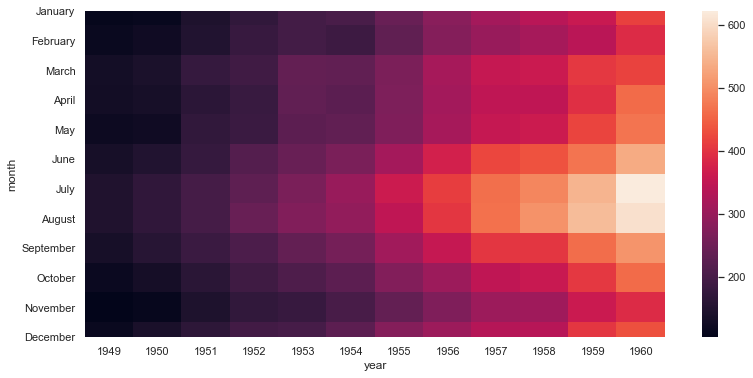

In [6]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)


In [7]:
hmap = df_crash.groupby([df_crash['CRASH DATE'].dt.month, df_crash['CRASH DATE'].dt.year])
hmap=hmap.size().unstack()

In [8]:
hmap = hmap.rename_axis(index={'CRASH DATE': 'Month'},columns={'CRASH DATE': 'Year'}).fillna(0).astype(int)

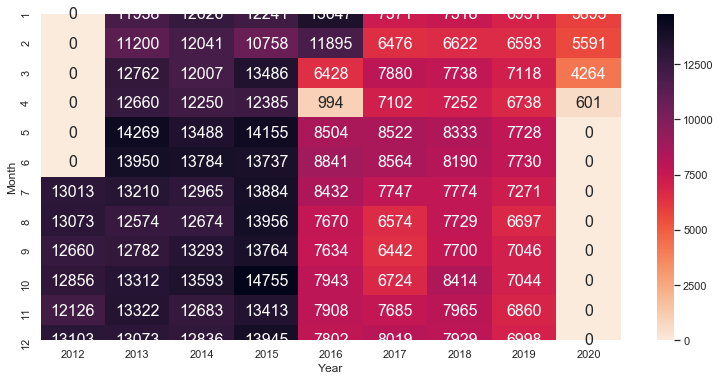

In [9]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(hmap,annot=True,fmt="d",annot_kws={"size": 16},cmap = cmap)

In [10]:
#sns.choose_light_palette() 

## Inteactive bokeh plot of dangerous intersections. 

In [11]:
total =df_crash.groupby('ON STREET NAME').size()

In [12]:
largest = total[total>4000].sort_values(ascending = True)

In [13]:
largest.values

array([ 4058,  4167,  4216,  4314,  4347,  4352,  4438,  4548,  5254,
        6387,  6397,  6829,  6853,  8271,  8751, 11060, 12057],
      dtype=int64)

In [14]:
street = [str(elem).rstrip() for elem in largest.index.to_list()]
street

['NOSTRAND AVENUE',
 'WOODHAVEN BOULEVARD',
 'JAMAICA AVENUE',
 '1 AVENUE',
 'HYLAN BOULEVARD',
 '7 AVENUE',
 '10 AVENUE',
 '8 AVENUE',
 '5 AVENUE',
 'FLATBUSH AVENUE',
 'QUEENS BOULEVARD',
 'LINDEN BOULEVARD',
 '2 AVENUE',
 'NORTHERN BOULEVARD',
 '3 AVENUE',
 'ATLANTIC AVENUE',
 'BROADWAY']

In [15]:
output_notebook()

Loading BokehJS ...

In [16]:
fruits = street
years = largest.values

data = {'fruits' : street,
        'count'   : largest.values}

source = ColumnDataSource(data=data)

p = figure(y_range=FactorRange(factors=fruits), x_range=(3000, 13000), plot_width=800,plot_height=400,title="Total recorded accidents ")
p.hbar(y='fruits', right='count', height=0.7, source=source)

#p.text([12000,12000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],[2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], text=[ str(i) for i in years], alpha=0.5, text_font_size="10pt", text_baseline="middle", text_align="center")

p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
show(p)

## BOKEH TESTS